In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col, count, isnan, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#!pip3 install pyspark

In [3]:
spark = SparkSession.builder \
                    .appName("Stellar EDA and Classification") \
                    .config("spark.dynamicAllocation.enabled", "true") \
                    .config("spark.dynamicAllocation.minExecutors", "2") \
                    .config("spark.dynamicAllocation.maxExecutors", "10") \
                    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/01 13:53:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


- **obj_ID**: Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
- **alpha**: Right Ascension angle (at J2000 epoch)
- **delta**: Declination angle (at J2000 epoch)
- **u**: Ultraviolet filter in the photometric system
- **g**: Green filter in the photometric system
- **r**: Red filter in the photometric system
- **i**: Near Infrared filter in the photometric system
- **z**: Infrared filter in the photometric system
- **run_ID**: Run Number used to identify the specific scan
- **rereun_ID**: Rerun Number to specify how the image was processed
- **cam_col**: Camera column to identify the scanline within the run
- **field_ID**: Field number to identify each field
- **spec_obj_ID**: Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
- **class**: Object class (galaxy, star, or quasar object)
- **redshift**: Redshift value based on the increase in wavelength
- **plate**: Plate ID, identifies each plate in SDSS
- **MJD**: Modified Julian Date, used to indicate when a given piece of SDSS data was taken
- **fiber_ID**: Fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

In [4]:
schema = StructType([
    StructField("obj_ID", FloatType(), True),
    StructField("alpha", FloatType(), True),
    StructField("delta", FloatType(), True),
    StructField("Ultraviolet filter", FloatType(), True),
    StructField("Green filter", FloatType(), True),
    StructField("Red filter", FloatType(), True),
    StructField("Near Infrared filter", FloatType(), True),
    StructField("Infrared filter", FloatType(), True),
    StructField("run_ID", IntegerType(), True),
    StructField("rerun_ID", IntegerType(), True),
    StructField("cam_col", IntegerType(), True),
    StructField("field_ID", IntegerType(), True),
    StructField("spec_obj_ID", FloatType(), True),
    StructField("class", StringType(), True),
    StructField("redshift", FloatType(), True),
    StructField("plate", IntegerType(), True),
    StructField("MJD", IntegerType(), True),
    StructField("fiber_ID", IntegerType(), True)
])

df = spark.read.csv('stellar_classification.csv', header=True, schema=schema)

df = df.select(
    'alpha', 'delta', 'Ultraviolet filter', 'Green filter', 'Red filter',
    'Near Infrared filter', 'Infrared filter', 'redshift',
    'plate', 'MJD', 'class'
)

In [5]:
df.dtypes

[('alpha', 'float'),
 ('delta', 'float'),
 ('Ultraviolet filter', 'float'),
 ('Green filter', 'float'),
 ('Red filter', 'float'),
 ('Near Infrared filter', 'float'),
 ('Infrared filter', 'float'),
 ('redshift', 'float'),
 ('plate', 'int'),
 ('MJD', 'int'),
 ('class', 'string')]

In [6]:
df.describe("delta").show()

+-------+------------------+
|summary|             delta|
+-------+------------------+
|  count|            100000|
|   mean|24.135304592672245|
| stddev|19.644665403352487|
|    min|        -18.785328|
|    max|          83.00052|
+-------+------------------+



In [7]:
null_counts = df.select([col(c).isNull().alias(c) for c in df.columns])

null_counts_per_column = null_counts.agg(*[
    count(col(c)).alias(c) for c in null_counts.columns
])

null_counts_dict = null_counts_per_column.first().asDict()

if all(null_counts_dict.values()):
    print("DataFrame does not contain null values.")
else:
    print("DataFrame contains null values.")

DataFrame does not contain null values.


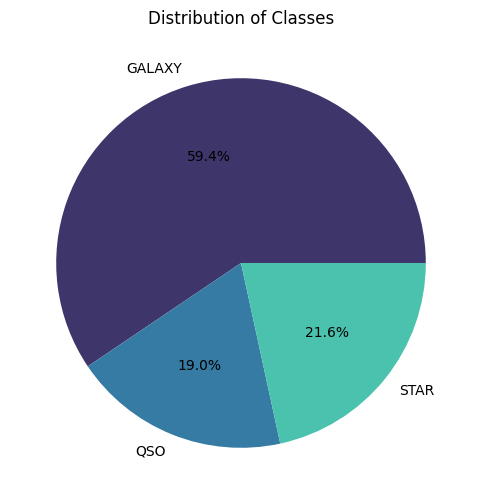

In [8]:
class_counts = df.groupBy('class').count().collect()
classes_row = df.select('class').distinct().collect()

classes = list(map(lambda row: row['class'], classes_row))

counts = [row['count'] for row in class_counts]

plt.figure(figsize=(8, 6))
plt.pie(counts, labels=classes, autopct='%1.1f%%', colors=['#3e356b', '#357ba3', '#4bc2ad'])
plt.title('Distribution of Classes')
plt.show()

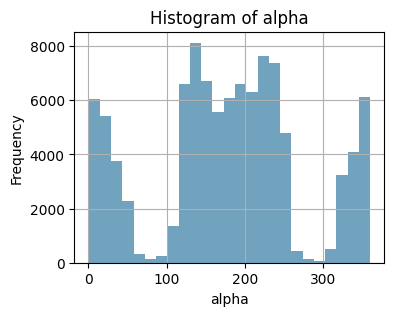

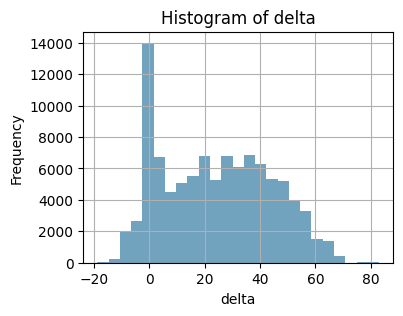

24/06/01 13:54:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u
 Schema: Ultraviolet filter
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


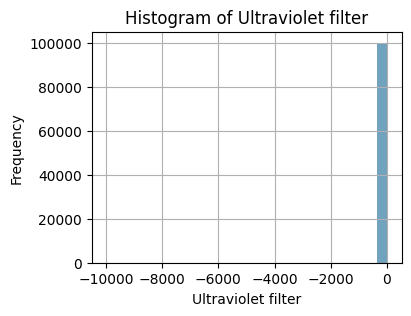

24/06/01 13:54:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: g
 Schema: Green filter
Expected: Green filter but found: g
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


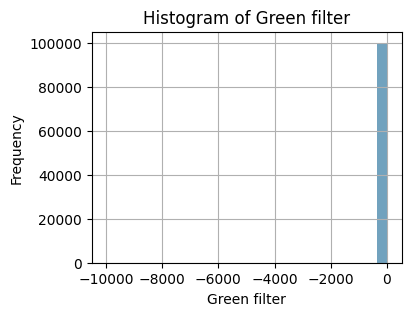

24/06/01 13:54:02 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: r
 Schema: Red filter
Expected: Red filter but found: r
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


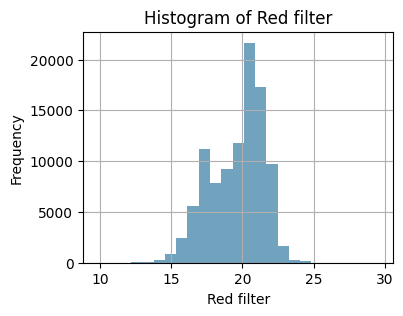

24/06/01 13:54:02 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: i
 Schema: Near Infrared filter
Expected: Near Infrared filter but found: i
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


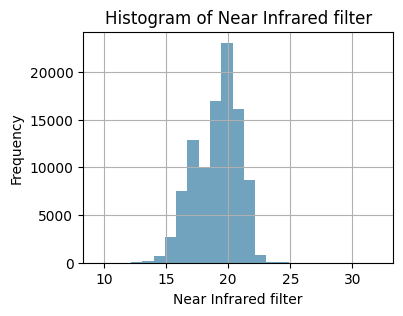

24/06/01 13:54:03 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: z
 Schema: Infrared filter
Expected: Infrared filter but found: z
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


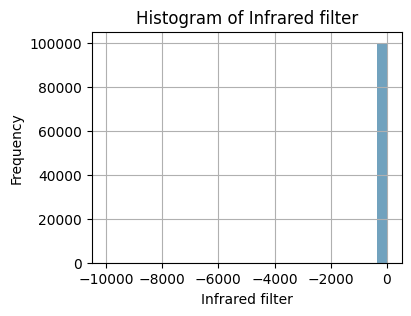

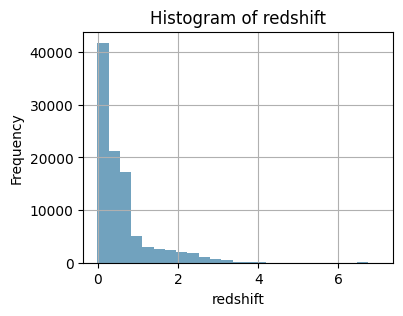

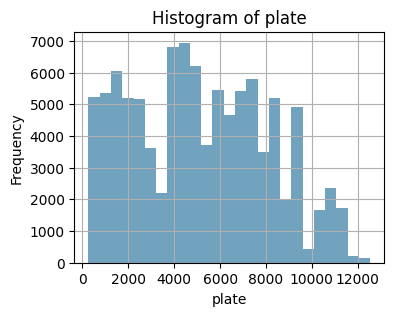

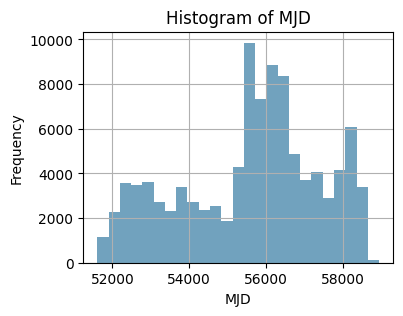

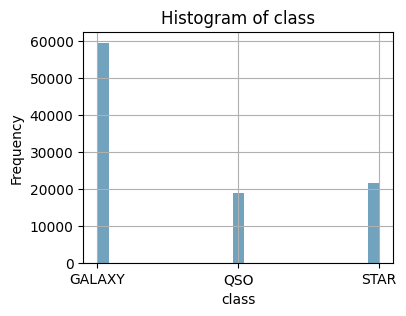

In [9]:
def plot_histograms(df, columns=df.columns):
    for col_name in columns:
        if df.schema[col_name] not in ['obj_ID', 'spec_obj_ID', 'class']:
            col_data = df.select(col_name).toPandas()
            
            # Plot histogram
            plt.figure(figsize=(4, 3))
            plt.hist(col_data[col_name], bins=25, color='#357ba3', alpha=0.7)
            plt.xlabel(col_name)
            plt.ylabel('Frequency')
            plt.title(f'Histogram of {col_name}')
            plt.grid(True)
            plt.show()

plot_histograms(df)

24/06/01 13:54:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u
 Schema: Ultraviolet filter
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv
24/06/01 13:54:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g
 Schema: Ultraviolet filter, Green filter
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv
24/06/01 13:54:08 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, z
 Schema: Ultraviolet filter, Green filter, Infrared filter
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv
24/06/01 13:54:09 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, z
 Schema: Ultraviolet filter, Green filter, Infrared filt

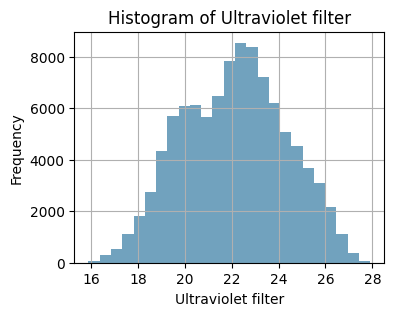

24/06/01 13:54:10 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, z
 Schema: Ultraviolet filter, Green filter, Infrared filter
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


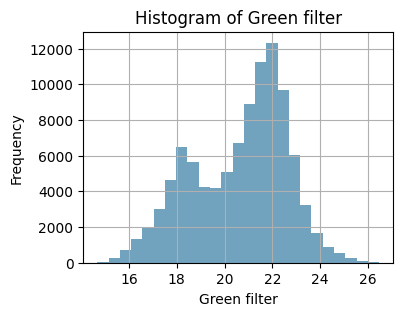

24/06/01 13:54:11 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, z
 Schema: Ultraviolet filter, Green filter, Infrared filter
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


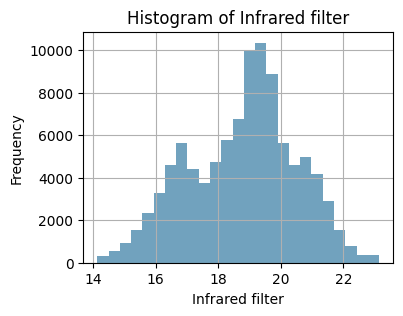

In [10]:
def remove_outliers(df, columns):
    for col_name in columns:
        # Calculating quartiles
        quartiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
        Q1 = quartiles[0]
        Q3 = quartiles[1]

        # Calculating the Interquartile region
        IQR = Q3 - Q1
        
        # Defining lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Removing outliers
        df = df.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))
    
    return df

df_cleaned = remove_outliers(df, ['Ultraviolet filter', 'Green filter', 'Infrared filter'])
plot_histograms(df_cleaned, ['Ultraviolet filter', 'Green filter', 'Infrared filter'])

24/06/01 13:54:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, r, i, z, class, redshift, plate, MJD
 Schema: Ultraviolet filter, Green filter, Red filter, Near Infrared filter, Infrared filter, class, redshift, plate, MJD
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


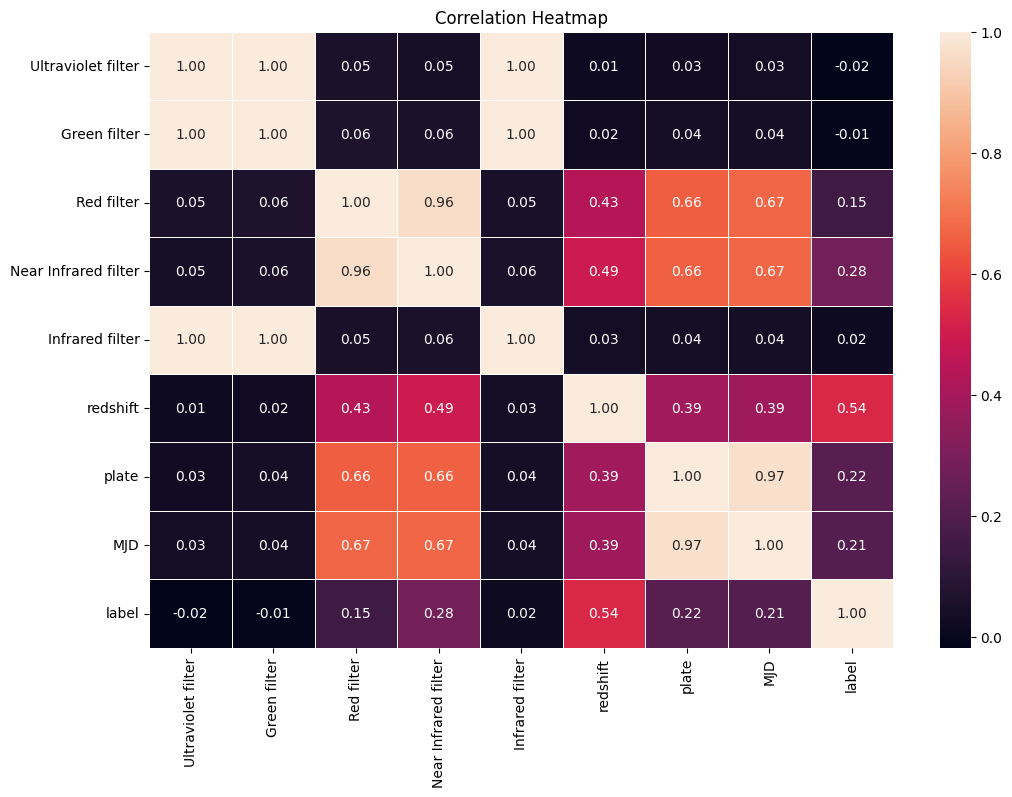

In [11]:
indexer = StringIndexer(inputCol='class', outputCol='label')
indexer_model = indexer.fit(df)
indexed_df = indexer_model.transform(df)

cols_to_drop = ['class', 'alpha', 'delta']
indexed_df = indexed_df.drop(*cols_to_drop)

pandas_df = indexed_df.toPandas()
correlation_matrix = pandas_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, linewidths=0.5, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [12]:
def plot_feature_pair(df, f1, f2):
    pandas_df = df.select(f1, f2, 'class').toPandas()
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=pandas_df, x=f1, y=f2, hue='class', palette='mako', s=10)
    
    plt.title('Scatter Plot of Two Features by Stellar Object')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.show()

24/06/01 13:54:15 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, i, z, class
 Schema: Ultraviolet filter, Green filter, Near Infrared filter, Infrared filter, class
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


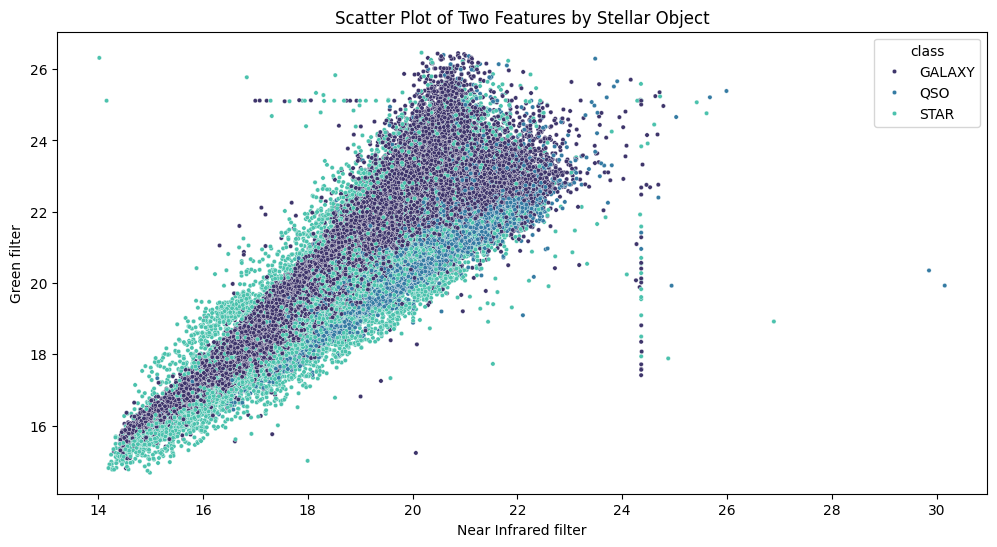

In [13]:
plot_feature_pair(df_cleaned, 'Near Infrared filter', 'Green filter')

24/06/01 13:54:17 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, z, class, redshift, plate
 Schema: Ultraviolet filter, Green filter, Infrared filter, class, redshift, plate
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


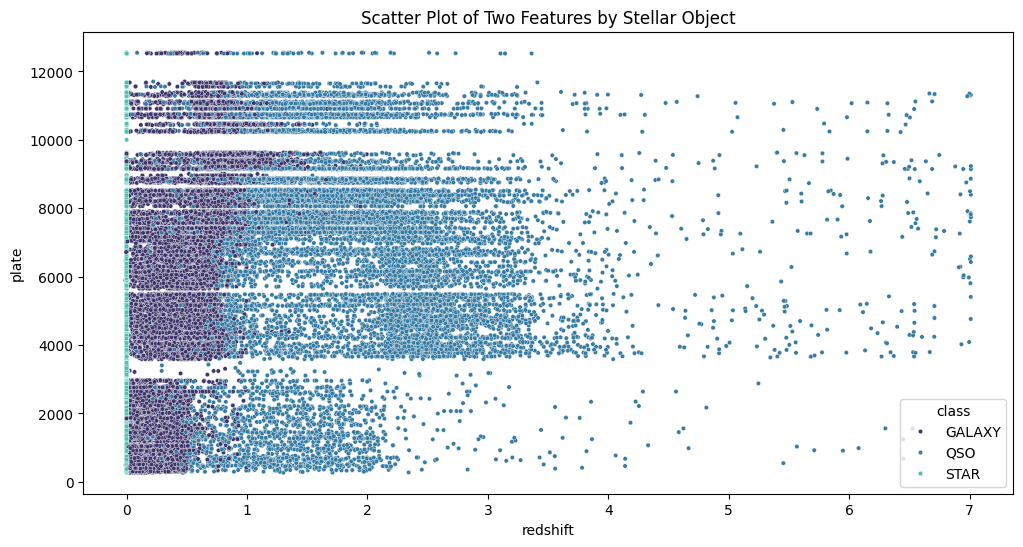

In [14]:
plot_feature_pair(df_cleaned, 'redshift', 'plate')

In [15]:
train, test = indexed_df.randomSplit([0.8, 0.2], seed=42)

In [16]:
# Excluding the last column, because it is 'label' which is not feature
features = indexed_df.columns[:-1]
features

['Ultraviolet filter',
 'Green filter',
 'Red filter',
 'Near Infrared filter',
 'Infrared filter',
 'redshift',
 'plate',
 'MJD']

In [17]:
assembler = VectorAssembler(inputCols=features, outputCol='features')

vec_train = assembler.transform(train)
vec_test = assembler.transform(test)

vec_train.select('features', 'label').show(10)

24/06/01 13:54:20 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, r, i, z, class, redshift, plate, MJD
 Schema: Ultraviolet filter, Green filter, Red filter, Near Infrared filter, Infrared filter, class, redshift, plate, MJD
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[12.2623996734619...|  1.0|
|[14.1519899368286...|  1.0|
|[14.5067796707153...|  0.0|
|[14.5690603256225...|  1.0|
|[14.6461696624755...|  1.0|
|[14.6572198867797...|  0.0|
|[14.9318199157714...|  1.0|
|[15.1561203002929...|  0.0|
|[15.2653999328613...|  0.0|
|[15.3584203720092...|  1.0|
+--------------------+-----+
only showing top 10 rows



In [30]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50, 
                            maxDepth=3, featureSubsetStrategy='sqrt')
model = rf.fit(vec_train)

24/06/01 13:55:32 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, r, i, z, class, redshift, plate, MJD
 Schema: Ultraviolet filter, Green filter, Red filter, Near Infrared filter, Infrared filter, class, redshift, plate, MJD
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv
24/06/01 13:55:32 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, r, i, z, class, redshift, plate, MJD
 Schema: Ultraviolet filter, Green filter, Red filter, Near Infrared filter, Infrared filter, class, redshift, plate, MJD
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv
24/06/01 13:55:32 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, r, i, z, class, redshift, plate, MJD
 Schema: Ultraviolet filter, Green filter, Red filter, Near Infrared

In [31]:
feature_importance = model.featureImportances
for feature_name, importance in zip(features, feature_importance):
    print(feature_name, importance)

Ultraviolet filter 0.0535292055064063
Green filter 0.038194252361277076
Red filter 0.011902267577911147
Near Infrared filter 0.05255671286260945
Infrared filter 0.10119509445784461
redshift 0.6995212619474501
plate 0.026424992466786
MJD 0.0166762128197153


In [32]:
# Making a prediction on test data
predictions = model.transform(vec_test)

In [33]:
# Computing accuracy and f1 score
accuracy_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(metricName="f1")

accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

print("Accuracy:", accuracy)
print("F1 sscore:", f1_score)

24/06/01 13:55:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, r, i, z, class, redshift, plate, MJD
 Schema: Ultraviolet filter, Green filter, Red filter, Near Infrared filter, Infrared filter, class, redshift, plate, MJD
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv
24/06/01 13:55:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, r, i, z, class, redshift, plate, MJD
 Schema: Ultraviolet filter, Green filter, Red filter, Near Infrared filter, Infrared filter, class, redshift, plate, MJD
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


Accuracy: 0.9369482976040353
F1 sscore: 0.9353395828354395


In [31]:
# Assuming "label" is your ground truth label column and "prediction" is the predicted label column
confusion_matrix = predictions.groupBy("label", "prediction").agg(count("*").alias("count"))

confusion_matrix_dataframe = confusion_matrix.toPandas()

confusion_matrix_dataframe

24/06/01 01:05:44 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: u, g, r, i, z, class, redshift, plate, MJD
 Schema: Ultraviolet filter, Green filter, Red filter, Near Infrared filter, Infrared filter, class, redshift, plate, MJD
Expected: Ultraviolet filter but found: u
CSV file: file:///Users/ghovhannes/Desktop/star_classification_project/stellar_classification.csv


,label,prediction,count
0,2.0,0.0,777
1,1.0,1.0,4166
2,0.0,1.0,108
3,1.0,0.0,114
4,2.0,2.0,2980
5,1.0,2.0,20
6,0.0,0.0,11456
7,0.0,2.0,203
8,2.0,1.0,1


In [32]:
confusion_matrix_with_counts = np.zeros(shape=(3, 3), dtype = np.int32)
for row in confusion_matrix_dataframe.iterrows():
    row_info = row[1]
    confusion_matrix_with_counts[int(row_info['label'])][int(row_info['prediction'])] = row_info['count']
confusion_matrix_with_counts

array([[11456,   108,   203],
       [  114,  4166,    20],
       [  777,     1,  2980]], dtype=int32)

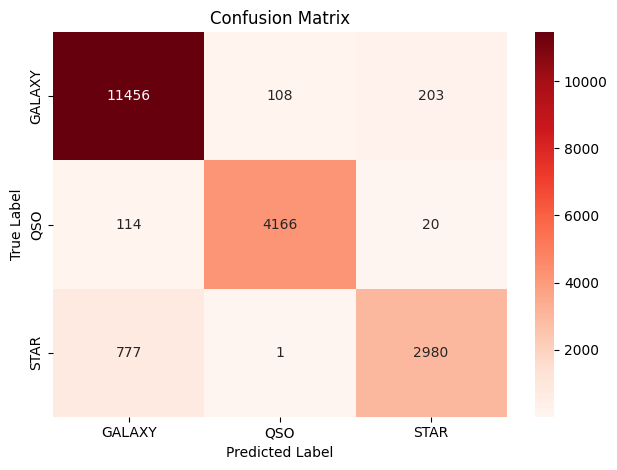

In [39]:
sns.heatmap(confusion_matrix_with_counts, annot=True, cmap="Reds", fmt="d", xticklabels=classes, yticklabels=classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.tight_layout()

plt.show()